In [1]:
import random
import numpy as np 
import gymnasium as gym
from gymnasium import spaces
import copy
import sys

import torch as th
from stable_baselines3 import A2C, DQN, PPO

from game_2048 import Game2048

In [2]:
N_DISCRETE_ACTIONS = 4
OBS_SPACE_LIM = [[8193 for _ in range(4)] for _ in range(4)]
TENSORBOARDS_LOGDIR = "./tensorboards"

In [3]:
class GameEnv(gym.Env):
    """Custom Environment that follows gym interface."""
    def __init__(self):
            super().__init__()

            self.game = Game2048()
            self.action_space = spaces.Discrete(4)
            self.observation_space = spaces.Box(low=-1, high=1, shape=(88,), dtype=np.float32)

            self.last_state = np.array(self.game.board)
            self.last_states = [copy.deepcopy(self.last_state) for _ in range(10)]
            self.total_steps = 0



    def step(self, action):

        current_state, reward_increment, done = self.game.move(action)
        current_state = np.array(current_state)
        self.update_memory(current_state)

        self.total_steps += 1

        future_outcomes, future_rewards = self.sim_ahead(current_state)
        stuck_future_outcomes = [np.array_equal(current_state, future_outcomes[i]) * 1 for i in range(4)]
        reward = self.count_empty_cells(current_state) - self.count_empty_cells(self.last_states[-2])
        observation = self.scale_observation(future_outcomes, stuck_future_outcomes, current_state, future_rewards)

        done =  np.array_equal(stuck_future_outcomes, np.ones(4))
        truncated =  all(np.array_equal(state, current_state) for state in self.last_states)
        info = {}
        return observation, reward, done, truncated, info


    def reset(self, seed=None, options=None):
        if seed is not None:
            self.game = Game2048(seed)
        else:
            self.game = Game2048()

        self.last_state = np.array(self.game.board)
        self.last_states = [copy.deepcopy(self.last_state) for _ in range(10)]
        current_state = np.array(self.game.board)
        self.update_memory(current_state)

        future_outcomes = [
            Game2048.left(current_state)[0],
            Game2048.right(current_state)[0],
            Game2048.up(current_state)[0],
            Game2048.down(current_state)[0]
        ]

        future_rewards = [
            Game2048.left(current_state)[1],
            Game2048.right(current_state)[1],
            Game2048.up(current_state)[1],
            Game2048.down(current_state)[1]
        ]

        stuck_future_outcomes = [np.array_equal(current_state, future_outcomes[i]) * 1 for i in range(4)]

        observation = self.scale_observation(future_outcomes, stuck_future_outcomes, current_state, future_rewards)
        info = {}
        return observation, info


    def render(self):
        self.game.render_board(self.game.board)

    def close(self):
        pass

    @staticmethod
    def count_empty_cells(board):
        return np.count_nonzero(np.array(board) == 0)
    
    @staticmethod
    def sim_ahead(board):
        directions = [Game2048.left, Game2048.right, Game2048.up, Game2048.down]
        future_outcomes = []
        future_rewards = []
        for direction in directions:
            outcome, reward = direction(board)
            outcome = np.array(outcome)
            future_outcomes.append(outcome)
            future_rewards.append(reward)

        
        return np.array(future_outcomes), np.array(future_rewards)


    def valid_action_mask(self):
        if 0 in self.game.board:
            return np.ones(4).astype(np.float32)
        
        valid_left = Game2048.left(self.game.board)[0] != self.game.board
        valid_right = Game2048.right(self.game.board)[0] != self.game.board
        valid_up = Game2048.up(self.game.board)[0] != self.game.board
        valid_down = Game2048.down(self.game.board)[0] != self.game.board
        return np.array([valid_left, valid_right, valid_up, valid_down]).astype(np.float32)
    
    def update_memory(self, new_state):
        self.last_states.pop(0)
        self.last_states.append(copy.deepcopy(new_state))


    def scale_observation(self, future_outcomes, stuck_future_outcomes, current_state, future_rewards):
        future_outcomes = np.array(future_outcomes)
        stuck_future_outcomes = np.array(stuck_future_outcomes)
        current_state = np.array(current_state)
        future_rewards = np.array(future_rewards)

        current_state = (current_state - 1024) / 1024
        future_rewards = (future_rewards - 1024) / 1024

        for i, outcome in enumerate(future_outcomes):
            outcome = (outcome - 1024) / 1024
            future_outcomes[i] = outcome

        observation = np.concatenate([current_state.ravel(), np.concatenate(future_outcomes).ravel(),
                        np.array(stuck_future_outcomes).astype(np.float32), future_rewards]).astype(np.float32)
        return observation

In [4]:
from stable_baselines3.common.env_checker import check_env
env = GameEnv()
check_env(env, warn=True)

del env

In [5]:
def evaluate(model, num_steps=100):
    scores = []
    boards = []

    score_ts = []
    board_ts = []



    for i in range(num_steps):
        score_timeline = []
        board_timeline = []
        env = GameEnv()
        obs, info = env.reset()
        done = False
        while not done:
            action, info = model.predict(obs, deterministic=True)
            action = int(model.predict(obs, deterministic=True)[0])
            obs, reward, done, truncated, info = env.step(action)
            done = done or truncated
            board_timeline.append(env.game.board)
            score_timeline.append(env.game.total_score)
        
        score_ts.append(score_timeline)
        board_ts.append(board_timeline)
        boards.append(env.game.board)
        scores.append(env.game.total_score)


    scores = np.array(scores)
    print(f"Average score: {scores.mean()}")

    best_board = boards[np.argmax(scores)]
    # print max score
    print(f'Max score: {np.max(scores)}')
    env.game.render_board(best_board)
    return scores, boards, score_ts, board_ts


In [6]:
from sb3_contrib.ppo_mask import MaskablePPO

def mask_fn(env: gym.Env) -> np.ndarray:
    # Do whatever you'd like in this function to return the action mask
    # for the current env. In this example, we assume the env has a
    # helpful method we can rely on.
    return env.valid_action_mask()

model = MaskablePPO.load("models/2048_MaskablePPO_Solved")

scores, boards, score_ts, board_ts = evaluate(model, 1000)

Average score: 5359.18
Max score: 13516
+-------------------+
| 2  | 4  | 8  | 4  |
+-------------------+
| 8  |256 |128 |256 |
+-------------------+
| 4  | 16 | 32 | 4  |
+-------------------+
| 2  |1024| 8  | 2  |
+-------------------+


In [7]:

empty_cells_ts = []
for board_timeline in board_ts:
    empty_cell_timeline = []
    for board in board_timeline:
        board = np.array(board)
        empty_cells = GameEnv.count_empty_cells(board)
        empty_cell_timeline.append(empty_cells)
    empty_cells_ts.append(empty_cell_timeline)



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [9]:
class GameStats:
    
    def __init__(self, board_timeline, score_timeline, empty_cells_timeline):
        self.score = score_timeline[-1]
        self.board_timeline = board_timeline
        self.score_timeline = score_timeline
        self.empty_cells_timeline = empty_cells_timeline
        self.final_board = board_timeline[-1]
        self.final_tile_counts = self.get_tile_counts(self.final_board) 
        self.timesteps = len(board_timeline)
        self.max_tile = np.max(self.final_board)


    def get_tile_counts(self, board):
        tile_counts = {}
        for tile in np.unique(board):
            if tile != 0:
                tile_counts[tile] = np.count_nonzero(board == tile)

        names = [0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
        for name in names:
            if name not in tile_counts:
                tile_counts[name] = 0
            
        return tile_counts

    def __repr__(self):
        return f"Score: {self.score}, Final tile counts: {self.final_tile_counts}, Timesteps: {self.timesteps}"


In [10]:
GAME_STAT = GameStats(board_ts[0], score_ts[0], empty_cells_ts[0])

In [11]:
GAME_STAT

Score: 10692, Final tile counts: {2: 2, 4: 3, 8: 4, 16: 1, 32: 2, 64: 2, 128: 1, 1024: 1, 0: 0, 256: 0, 512: 0, 2048: 0}, Timesteps: 624

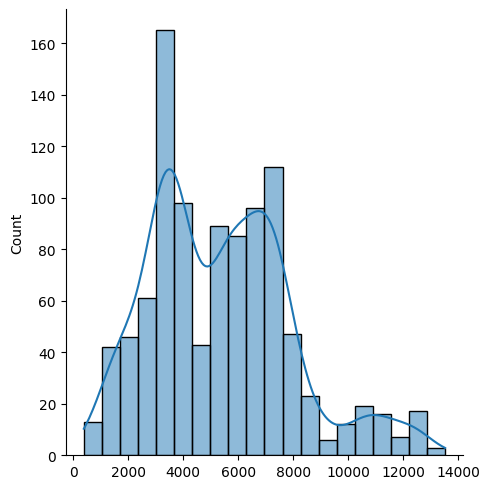

In [12]:
# plot distribution of scores using displot
sns.displot(scores, kde=True, bins=20)


In [13]:
# plot percentages by max tile
max_tiles = []
for board in boards:
    max_tiles.append(np.max(board))

max_tiles = np.array(max_tiles)

max_tiles = pd.Series(max_tiles)

max_tiles.value_counts(normalize=True).sort_index().plot(kind='bar', backend='plotly')